In [139]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
data = pd.read_csv("/Users/Yuei/Downloads/credit.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_status           1000 non-null object
duration                  1000 non-null int64
credit_history            1000 non-null object
purpose                   1000 non-null object
credit_amount             1000 non-null int64
savings_status            1000 non-null object
employment                1000 non-null object
installment_commitment    1000 non-null int64
personal_status           1000 non-null object
other_parties             1000 non-null object
residence_since           1000 non-null int64
property_magnitude        1000 non-null object
age                       1000 non-null int64
other_payment_plans       1000 non-null object
housing                   1000 non-null object
existing_credits          1000 non-null int64
job                       1000 non-null object
num_dependents            1000 non-null int64
own_telephone             1000 non-null object
foreign_

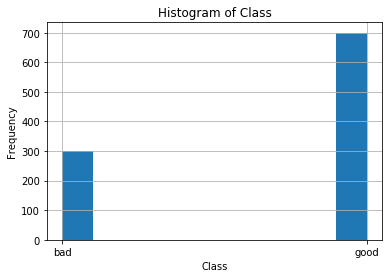

In [140]:
data["class"].hist()
plt.title("Histogram of Class")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [189]:
maxLength = 0
att = ""
for attribute in data.columns:
    if(type(data[attribute][0]) == str):
        if(maxLength < len(data[attribute].unique())):
            maxLength = len(data[attribute].unique())
            att = attribute
print(maxLength)
print(data[att].unique())

10
['radio/tv' 'education' 'furniture/equipment' "'new car'" "'used car'"
 'business' "'domestic appliance'" 'repairs' 'other' 'retraining']


The dataset has totally 21 features and 1000 sample, for every feature in dataset, there is not null value so that we don't need to process null value data and the completeness of this dataset is relatively good. Among these features, there are 7 features are numerical value, others are classify by string. Among these non-numeric attributes, attrubite "purpose" has largest unique value: 10. They are shown above. As for label, it is credit risk, there are two classes: good and bad. The distribution of class is shown above. There are 700 samples are good, 300 samples are bad. The quantity of this dataset might not be large enough to make precise prediction. 

In [141]:
# draw stacked histogram 
# attribute: attribute name, ex: checking_sum
# data: dataset dataframe 
def drawHistogram(attribute, data):
    pivot_df = pd.DataFrame({attribute:data[attribute],
                   'class':data['class']}).pivot_table(index=attribute, columns='class', aggfunc=len, fill_value=0)
    pivot_df.loc[:,['good','bad']].plot.bar(stacked=True, color=['r', 'g'])
    plt.title("Histogram of "+ attribute +" and Class")
    plt.ylabel("Frequency")
    plt.show()

In [142]:
# encode label: map good to 1, bad to 0
# data: list of label
def encodeLabel(data):
    labels = []
    le = preprocessing.LabelEncoder()
    le.fit(data["class"].unique())
    encodedLabel = le.transform(data["class"])
    encodedLabel = np.asarray(encodedLabel)
    encodedLabel = encodedLabel.reshape((1000,1))
    return encodedLabel

In [143]:
# encode all categorical attribute into numerical value
def targetEncoder(trainData, testData, trainLabel):
    xTrain = np.zeros((trainData.shape[0],1))
    xTest = np.zeros((testData.shape[0],1))
    for i in range(trainData.shape[1]):
        if(type(trainData[0][i]) == str):
            encoder = ce.TargetEncoder()
            encoder.fit(trainData[:,i], trainLabel)
            encodedTrain = encoder.transform(trainData[:,i])
            encodedTrain = np.asarray(encodedTrain)
            encodedTrain = encodedTrain.reshape((trainData.shape[0],1))
            encodedTest = encoder.transform(testData[:,i])
            encodedTest = np.asarray(encodedTest)
            encodedTest = encodedTest.reshape((testData.shape[0],1))
            xTrain = np.append(xTrain, encodedTrain, axis = 1)
            xTest = np.append(xTest, encodedTest, axis = 1)
        else:
            trainFeature = np.asarray(trainData[:,i])
            trainFeature = trainFeature.reshape((trainData.shape[0],1))
            testFeature = np.asarray(testData[:,i])
            testFeature = testFeature.reshape((testData.shape[0],1))
            xTrain = np.append(xTrain, trainFeature, axis = 1)
            xTest = np.append(xTest, testFeature, axis = 1)
    return xTrain[:,1:], xTest[:,1:] 

In [144]:
# draw ROC curve
# clf: classfier model
# encodedTrain: encoded data set
# yTrain: encoded label corresponding to encodedTrain
def ROC(clf, encodedTrain, yTrain):
    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(encodedTrain, yTrain):
        probas_ = clf.fit(encodedTrain[train], yTrain[train]).predict_proba(encodedTrain[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(yTrain[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [145]:
# calulate accuracy
# pred: prediction
# label: true label
def accuracy(pred, label):
    correct = 0
    for i in range(pred.shape[0]):
        if(pred[i] == label[i]):
            correct+=1
    return (correct/pred.shape[0])

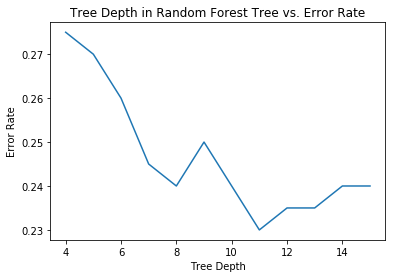

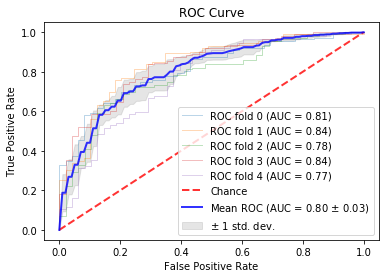

In [181]:
labels = encodeLabel(data)
data_ = np.asarray(data)
features = data_[:,0:-1]
xTrain, xTest, yTrain, yTest = train_test_split(features, labels, test_size = 0.2, random_state = 0)
encodedTrain, encodedTest = targetEncoder(xTrain, xTest, yTrain)   
yTrain = np.ravel(yTrain)
error = []
for i in range(4, 16):
    clf = RandomForestClassifier(n_estimators=encodedTrain.shape[0], max_depth=i,random_state = 0)
    clf.fit(encodedTrain, yTrain)
    predict = clf.predict(encodedTest)
    error.append(1-accuracy(predict, yTest))

plt.plot([i for i in range(4, 16)], error)
plt.xlabel("Tree Depth")
plt.ylabel("Error Rate")
plt.title("Tree Depth in Random Forest Tree vs. Error Rate")
plt.show()
clf = RandomForestClassifier(n_estimators=800, max_depth=11,random_state = 0)
ROC(clf, encodedTrain, yTrain)

In [182]:
predict = clf.predict(encodedTest)
acc = accuracy(predict, yTest)
print("The accuracy in test data is " + str(acc*100) + "%")

The accuracy in test data is 76.0%


Since there are many categorical features, they need to be encoded to numerical value. Therefore, I apply target encoding method to map the string value into numerical value. Then, in machine learning algorithm, I choose random forest to make prediction. To examine the performance of this model, I separate the data into two parts: training set and testing set in ratio 8:2. Apply training set to train my model: random forest, then test model in testing set. I firstly use accuracy(the number of correct prediction/total prediction) to examine the performance of model. In order to choose best hyperparameter: tree depth in model, I ran several times in different tree depth from 4 to 15 and record their accuracy. The figure above state the result. We could see that when tree depth is 11, the error rate is lowest. Thus, I use tree depth 11 and apply k folds cross validation to examine model performance. The above diagram is ROC curve, the larger area under curver(AUC) is, the performance of this model is better. From the above diagram, the average AUC is about 0.8/1.0. Since it is two class classfication problem, the probability of random guess is 0.5, the red dotted line means random guess. Using this model to run in test set, the accuracy is 76%. It is not high enough, I think that this is because the number of sample is relatively small and the number of features is large. 

Random Forest:    
Random forest is a kind of decision tree, decision tree is using many if else condition to make classification, for a people, if his whole attributes satisfy all condition of good credit, then, decision tree would recognize he has good credit. Below is a simple example of decision tree.    
![image](https://cdn-images-1.medium.com/max/1600/1*TlTzgt8I_5dUSbMZmRKyqQ.jpeg)

In [199]:
importance = clf.feature_importances_
d = {'attribute': data.columns[0:-1], 'importance': importance}
df = pd.DataFrame(data=d)
df.sort_values(by=['importance'])
df

,attribute,importance
0,checking_status,0.118819
1,duration,0.106082
2,credit_history,0.071597
3,purpose,0.072760
4,credit_amount,0.125475
5,savings_status,0.051224
6,employment,0.049811
7,installment_commitment,0.041857
8,personal_status,0.036057
9,other_parties,0.020941


Feature importances means how important this feature is, in other words, the largest value means corresponding factor affect result most. From above table, the three most importance factor is checking_status, duration and credit_history. The least importance factor is foreign_worker. The below diagram state the relationship between these factors and label. 

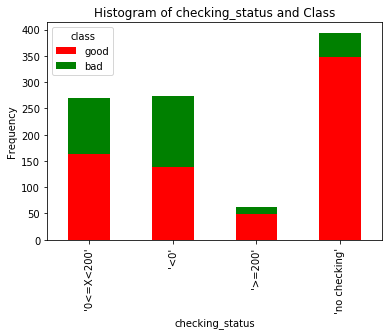

In [130]:
drawHistogram("checking_status",data)

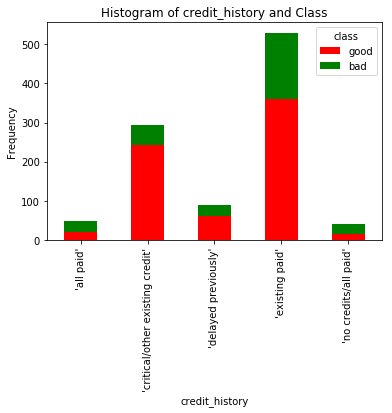

In [96]:
drawHistogram("credit_history",data)

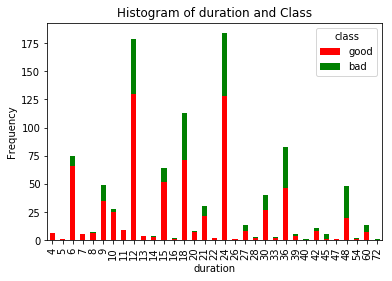

In [200]:
drawHistogram("duration",data)

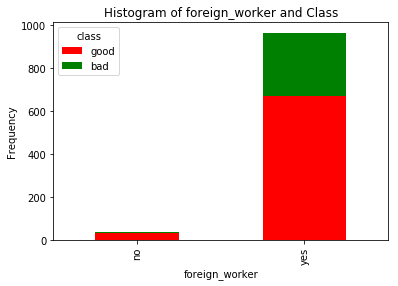

In [201]:
drawHistogram("foreign_worker",data)

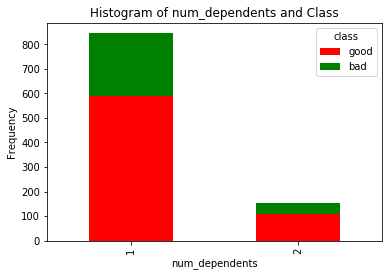

In [202]:
drawHistogram("num_dependents",data)

From the above histogram diagram, we could see that in checking_status diagram, if people have checking, the smaller the checking is, the probability of bad credit is larger. As for credit history, people with existing paid have higher probability to have bad credit. In duration factor, the shorter time period is, the probability of bad credit is smaller. Moreover, we could see that the importance factor have more unique values rather than binary choice. 